In [3]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths, DATA_DIRECTORY_PATH
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRESpatialTimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [4]:
n_neighbours = 5
neighbours_path = f"{DATA_DIRECTORY_PATH}/neighbours/{n_neighbours}.json"
with open(neighbours_path) as fd:
     neighbours = json.load(fd)
     print(f"E.g. Maps 1100 to {list(neighbours['1100'].keys())}") 

E.g. Maps 1100 to ['1203', '1234', '1217', '1423', '1231']


### Config


In [ ]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "gmean"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"
log_normalized_metric_pct_chg = metric_pct_chg + "_log_normalized_yearly"

In [26]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [27]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [31]:
asset_types_to_train = list(asset_types.keys())
# asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = [
    "count",
    metric,
    "yearly_price_growth"
]
core_normalize_columns = ["count_growth"]
core_maintain_columns = ["metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [32]:
# feature_columns = factor_columns + combined_core_columns + ["land", "condo"]
feature_columns = factor_columns + ["land", "condo"]
neighbour_feature_columns = factor_columns + combined_core_columns

### Dataset Prep


In [33]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
# df = get_most_active_municipalities(df, count_column="building_count", n=1000)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: train_df[
        ~train_df[f"{asset_type}_{metric_pct_chg}"].isna()
    ].reset_index(drop=True)
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: eval_df[~eval_df[f"{asset_type}_{metric_pct_chg}"].isna()].reset_index(
        drop=True
    )
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}")


land -> Train: (15535, 84), Eval: (2565, 84)
building -> Train: (13880, 84), Eval: (2299, 84)
condo -> Train: (3935, 84), Eval: (641, 84)


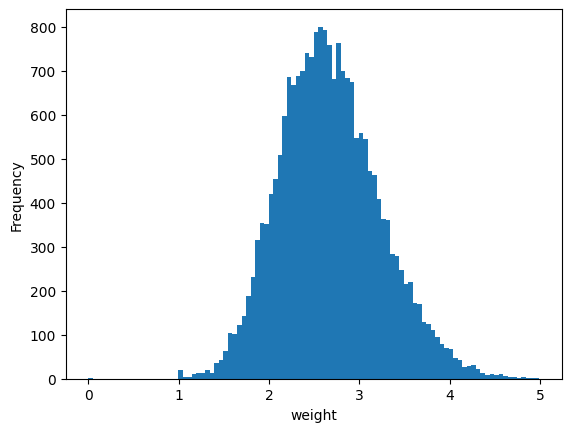

In [34]:
ax = df["weight"].plot.hist(bins=100)
ax.set_xlabel("weight")

plt.show()

In [35]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]
tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg = (
    f"{asset_type}_{metric}",
    f"{asset_type}_{metric_pct_chg}",
    f"{asset_type}_{normalized_metric_pct_chg}",
)

tmp_train_df[(tmp_train_df["area_code"] == "13101")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_normalized_yearly
33,2007,2.493287e+06,0.316351,0.857928
79,2008,2.469166e+06,0.169054,0.340934
1104,2009,1.871767e+06,-0.249277,-0.586656
1264,2010,2.011452e+06,-0.185372,-0.273030
2607,2011,1.576321e+06,-0.157843,-0.500078
4491,2012,1.617590e+06,-0.195810,-0.516639
4801,2013,2.345511e+06,0.487965,1.188551
6160,2014,2.188612e+06,0.353008,0.849007
7511,2015,2.334554e+06,-0.004671,-0.138765
8705,2016,2.480655e+06,0.133438,0.115214


In [36]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13101")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_normalized_yearly
356,2021,4.076227e+06,0.338402,0.578107
1891,2022,3.841535e+06,0.006987,-0.079650


In [37]:
idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13101")].index[-1]
row = tmp_eval_df.iloc[idx]
target = row[tmp_normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[(df["area_code"] == area_code) & (df["year"] <= year - years_ahead)]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window[factor_columns + combined_core_columns]

Target: -0.0796497104960709


,population_log_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_log_normalized_yearly,migrations_is_available,land_count_log_normalized_yearly,building_count_log_normalized_yearly,condo_count_log_normalized_yearly,land_unit_price_gmean_log_normalized_yearly,building_unit_price_gmean_log_normalized_yearly,condo_unit_price_gmean_log_normalized_yearly,land_yearly_price_growth_log_normalized_yearly,building_yearly_price_growth_log_normalized_yearly,condo_yearly_price_growth_log_normalized_yearly,land_count_growth_normalized_yearly,building_count_growth_normalized_yearly,condo_count_growth_normalized_yearly,land_metric_pct_chg_is_available,building_metric_pct_chg_is_available,condo_metric_pct_chg_is_available
12667,0.523614,2.529351,2.185336,2.094106,3.492520,1.398109,1,-0.802417,0.300977,1.265443,3.903895,3.821902,3.083753,0.067507,0.190340,0.223304,-0.358438,0.148372,0.207397,1.0,1.0,1.0
13917,0.534038,1.049901,0.683621,2.377324,3.297790,0.847408,1,-1.042696,0.146884,1.278458,4.098000,4.153827,3.053992,0.766808,1.304605,0.261653,-0.615019,-0.602199,-0.022409,1.0,1.0,1.0
15390,0.546386,1.477077,1.144115,4.286698,1.385719,1.107576,1,-1.966847,0.188094,1.213384,4.179623,3.986395,3.101524,0.707244,-0.515672,-0.079565,-1.570495,0.000373,-0.399847,1.0,1.0,1.0
16058,0.567887,2.826888,1.936817,3.673304,1.058187,2.588592,1,-0.972977,0.168692,1.102124,3.971509,3.893242,3.082521,-0.724808,-0.057283,0.144825,4.639863,-0.193218,-0.490898,1.0,1.0,1.0
17510,0.586892,-0.738705,-1.899583,1.994460,3.062750,2.497843,1,-0.599206,-0.294184,1.110556,4.118955,3.994217,3.115995,0.532732,0.567025,0.287609,1.040920,-1.287465,-0.133935,1.0,1.0,1.0


In [38]:
time_series_dataset = JapanRESpatialTimeSeriesDataset(
    df,
    tmp_train_df,
    neighbours_dictionary=neighbours,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    neighbour_feature_columns=neighbour_feature_columns,
    shift=years_ahead,
)

time_series_dataset_transformed = JapanRESpatialTimeSeriesDataset(
    df,
    tmp_train_df,
    neighbours_dictionary=neighbours,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    neighbour_feature_columns=neighbour_feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead,
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 124) (1,) [0.05493913] [3.17940516]
1 (1, 124) (1,) [0.94500859] [3.10573721]
2 (1, 124) (1,) [-0.5560255] [2.18038277]
3 (1, 124) (1,) [1.7012365] [2.72400264]
0 torch.Size([5, 124]) torch.Size([1]) tensor([0.0549]) tensor([3.1794])
1 torch.Size([5, 124]) torch.Size([1]) tensor([0.9450]) tensor([3.1057])
2 torch.Size([5, 124]) torch.Size([1]) tensor([-0.5560]) tensor([2.1804])
3 torch.Size([5, 124]) torch.Size([1]) tensor([1.7012]) tensor([2.7240])


In [39]:
BATCH_SIZE = 256

In [40]:
train_datasets = {
    asset_type: JapanRESpatialTimeSeriesDataset(
        df,
        train_dfs[asset_type],
        neighbours_dictionary=neighbours,
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        neighbour_feature_columns=neighbour_feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRESpatialTimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        neighbours_dictionary=neighbours,
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        neighbour_feature_columns=neighbour_feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
        shift=years_ahead,
    )
    for asset_type in asset_types_to_train
}

In [41]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [42]:
len(train_dataloader)

131

### Building the Transformer Model


In [43]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [51]:
# n_features = len(feature_columns)
n_features = len(feature_columns) + n_neighbours * (len(neighbour_feature_columns) + 1) # plus 1 for distance
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)

In [52]:
print(model)

TimeSeriesTransformerModel(
  (embedding): Linear(in_features=124, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


In [53]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())

        break

torch.Size([256, 5, 124]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 3.718395709991455


In [54]:
learning_rate = 1e-4  # 3e-4
weight_decay = 1  # 1
num_epochs = 1000

In [55]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [56]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 10.0867, Eval Loss: 10.4424
Train R^2: -0.0140, Eval R^2: -0.0011
Epoch: 1
Train Loss: 9.9463, Eval Loss: 10.4278
Train R^2: -0.0009, Eval R^2: -0.0002
Epoch: 2
Train Loss: 9.9412, Eval Loss: 10.4494
Train R^2: -0.0004, Eval R^2: -0.0023
Epoch: 3
Train Loss: 9.9347, Eval Loss: 10.4802
Train R^2: 0.0001, Eval R^2: -0.0056
Epoch: 4
Train Loss: 9.9206, Eval Loss: 10.4750
Train R^2: 0.0013, Eval R^2: -0.0055
Epoch: 5
Train Loss: 9.9035, Eval Loss: 10.5680
Train R^2: 0.0027, Eval R^2: -0.0145
Epoch: 6
Train Loss: 9.8959, Eval Loss: 10.6709
Train R^2: 0.0034, Eval R^2: -0.0248
Epoch: 7
Train Loss: 9.8750, Eval Loss: 11.2245
Train R^2: 0.0050, Eval R^2: -0.0803
Epoch: 8
Train Loss: 9.8466, Eval Loss: 10.7922
Train R^2: 0.0075, Eval R^2: -0.0362
Epoch: 9
Train Loss: 9.8303, Eval Loss: 10.6126
Train R^2: 0.0089, Eval R^2: -0.0199
Epoch: 10
Train Loss: 9.7988, Eval Loss: 10.9373
Train R^2: 0.0108, Eval R^2: -0.0497
Epoch: 11
Train Loss: 9.7725, Eval Loss: 11.0961
Train R^2: 

KeyboardInterrupt: 

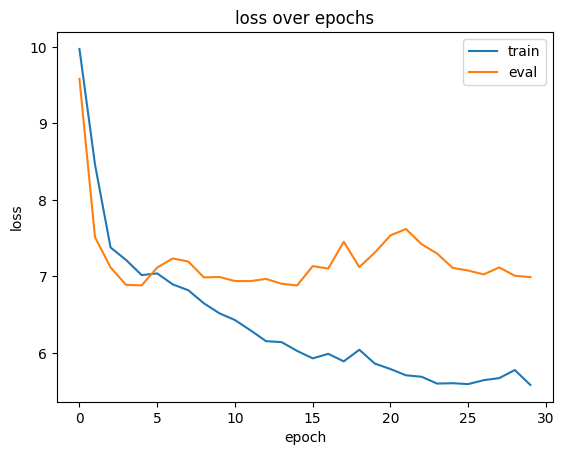

In [27]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

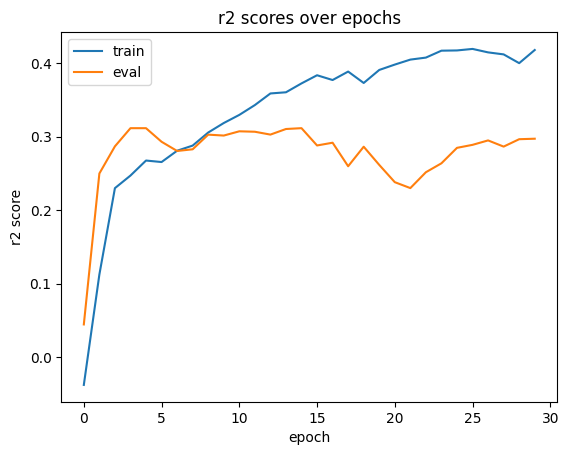

In [28]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [135]:
years = [2020, 2021, 2022]  # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(
        model, row["area_code"], row["year"], row["asset_type"]
    ),
    axis=1,
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

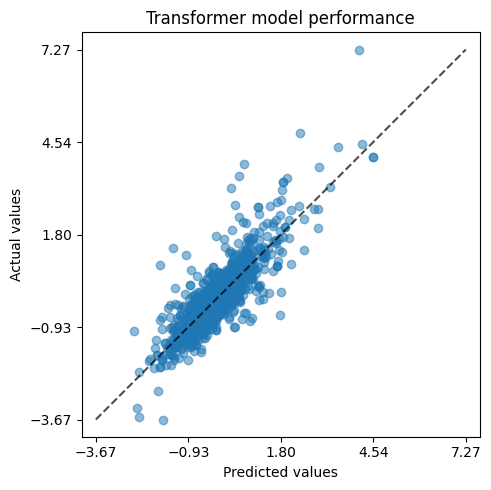

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

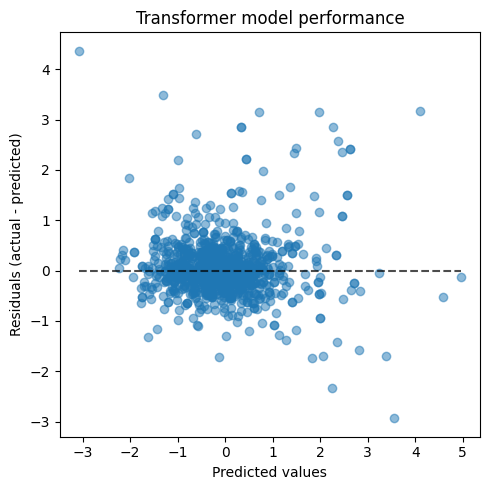

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()